In [1]:
import os
### QAOA_realestate가 있는 폴더로 지정
dir_path = "/Users/minhyeong-gyu/Documents/GitHub/QuantumVariableSelection"
os.chdir(dir_path)
import sys
module_path = dir_path + "/Module"
if module_path not in sys.path:
    sys.path.append(module_path)

from optimizer import optimizer as opt
from optimizer import basefunctions as bf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import font_manager, rc
# 윈도우 한글 폰트
# font_path = "C:/Windows/Fonts/NGULIM.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

# Mac 한글 폰트
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns
from dwave.system import LeapHybridCQMSampler
%matplotlib inline

In [2]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(drop="first")

In [3]:
data1 = pd.read_csv("./data/read_data_logistic/1.adult.data",header=None)
y = np.array([0 if i == " <=50K" else 1 for i in data1.iloc[:,14]])
x_conti = data1.iloc[:,[0,2,4,10,11,12]]
x_dummy = enc.fit_transform(data1.iloc[:,[8,9]]).toarray()
X = np.concatenate([x_conti,x_dummy],axis=1)
y_type = "binary"
lmbd = 0.01
n_features=7

In [4]:
sa_mi = opt.SimulatedAnnealing("QUBO",y_type=y_type,measure="mi")
sa_mi_result = sa_mi.optimize(X,y,lmbd,reps=10,n_features=n_features)
sa_full = opt.SimulatedAnnealing("QUBO",y_type=y_type,measure="full")
sa_full_result = sa_full.optimize(X,y,lmbd,reps=10,n_features=n_features)
sa_partial = opt.SimulatedAnnealing("QUBO",y_type=y_type,measure="partial")
sa_partial_result = sa_partial.optimize(X,y,lmbd,reps=10,n_features=n_features)
X_mi = X[:,sa_mi_result.astype(bool)]
X_full = X[:,sa_full_result.astype(bool)]
X_partial = X[:,sa_partial_result.astype(bool)]
datasets = [X,X_mi,X_full,X_partial]
rsquared_list = []
CN_list = []
for i in range(4) :
    dataset = datasets[i]
    rsquared_list += [bf.get_neg_entropy_cv(dataset,y)]
    CN_list += [bf.get_CN(dataset)]
result = pd.DataFrame([rsquared_list,CN_list])
result.index = ["MSPE","CN"]
result.columns = ["Full","MIC","Ord R2","Partial R2"]
result1 = result
result

/Users/minhyeong-gyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/minhyeong-gyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

,Full,MIC,Ord R2,Partial R2
MSPE,0.797549,0.815577,0.815577,0.800160
CN,7.280370,1.422460,1.422460,1.169265


/Users/minhyeong-gyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/minhyeong-gyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/minhyeong-gyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1508, in fit
    X, y = self._validate_data(
  File "/Users/minhyeong-gyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 581, in _validate_data

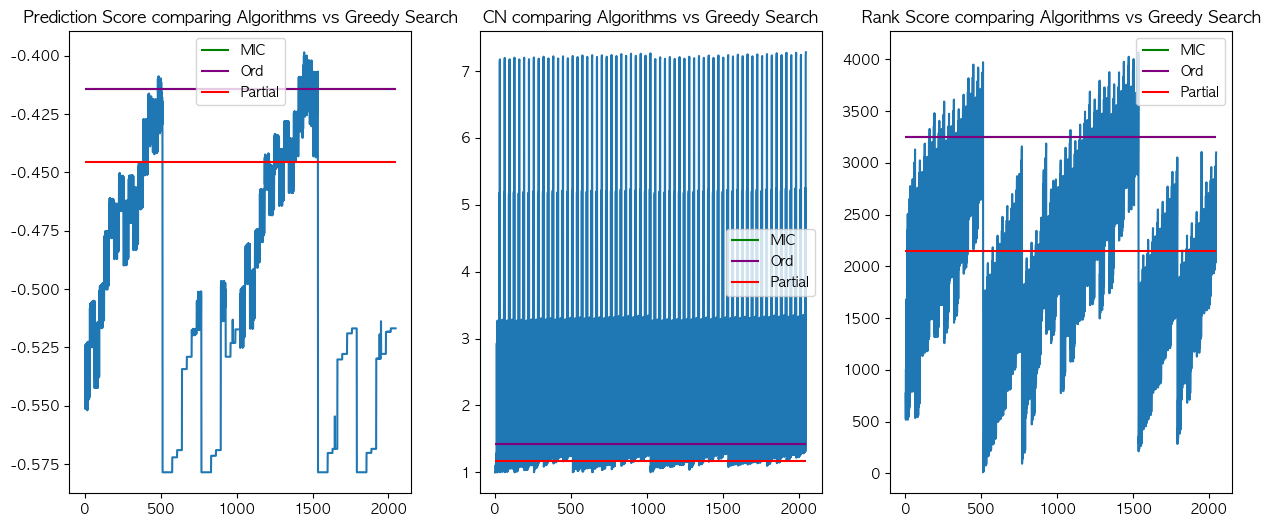

In [6]:
pred_score_list_greedy = []
CN_list_greedy = []
p = X.shape[1]
index_list = pd.DataFrame([list(format(i, '0'+str(p)+'b')) for i in range(2**p)]).applymap(int).applymap(bool)
for i in index_list.values :
    dataset = X[:,i]
    pred_score_list_greedy += [bf.get_neg_entropy_cv(dataset,y)]
    CN_list_greedy += [bf.get_CN(dataset)]
rank_list_greedy = pd.Series(pred_score_list_greedy).rank()+pd.Series(CN_list_greedy).rank()

mi_num = int("".join(sa_mi_result.astype(int).astype(str)),2)
ord_num = int("".join(sa_full_result.astype(int).astype(str)),2)
partial_num = int("".join(sa_partial_result.astype(int).astype(str)),2)

plt.figure(figsize = (15,6))
plt.subplot(131)
plt.plot(range(2**p),pred_score_list_greedy)
plt.hlines(pred_score_list_greedy[mi_num],0,2**p,colors="green",label="MIC")
plt.hlines(pred_score_list_greedy[ord_num],0,2**p,colors="purple",label="Ord")
plt.hlines(pred_score_list_greedy[partial_num],0,2**p,colors="red",label="Partial")
plt.title("Prediction Score comparing Algorithms vs Greedy Search")
plt.legend()

plt.subplot(132)
plt.plot(range(2**p),CN_list_greedy)
plt.hlines(CN_list_greedy[mi_num],0,2**p,colors="green",label="MIC")
plt.hlines(CN_list_greedy[ord_num],0,2**p,colors="purple",label="Ord")
plt.hlines(CN_list_greedy[partial_num],0,2**p,colors="red",label="Partial")
plt.title("CN comparing Algorithms vs Greedy Search")
plt.legend()

plt.subplot(133)
plt.plot(range(2**p),rank_list_greedy)
plt.hlines(rank_list_greedy[mi_num],0,2**p,colors="green",label="MIC")
plt.hlines(rank_list_greedy[ord_num],0,2**p,colors="purple",label="Ord")
plt.hlines(rank_list_greedy[partial_num],0,2**p,colors="red",label="Partial")
plt.title("Rank Score comparing Algorithms vs Greedy Search")
plt.legend()

In [3]:
data2 = pd.read_csv("./data/read_data_logistic/2.breast_cancer.csv")
y = data2.iloc[:,9].values
X = data2.iloc[:,:9].values
y_type = "binary"
lmbd = 0.01
n_features=5

In [6]:
sa_mi = opt.SimulatedAnnealing("QUBO",y_type=y_type,measure="mi")
sa_mi_result = sa_mi.optimize(X,y,lmbd,reps=10,n_features=n_features)
sa_full = opt.SimulatedAnnealing("QUBO",y_type=y_type,measure="full")
sa_full_result = sa_full.optimize(X,y,lmbd,reps=10,n_features=n_features)
sa_partial = opt.SimulatedAnnealing("QUBO",y_type=y_type,measure="partial")
sa_partial_result = sa_partial.optimize(X,y,lmbd,reps=10,n_features=n_features)
X_mi = X[:,sa_mi_result.astype(bool)]
X_full = X[:,sa_full_result.astype(bool)]
X_partial = X[:,sa_partial_result.astype(bool)]
datasets = [X,X_mi,X_full,X_partial]
rsquared_list = []
CN_list = []
for i in range(4) :
    dataset = datasets[i]
    rsquared_list += [bf.get_neg_entropy_cv(dataset,y)]
    CN_list += [bf.get_CN(dataset)]
result = pd.DataFrame([rsquared_list,CN_list])
result.index = ["MSPE","CN"]
result.columns = ["Full","MIC","Ord R2","Partial R2"]
result2 = result
result

/Users/minhyeong-gyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/minhyeong-gyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/minhyeong-gyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1508, in fit
    X, y = self._validate_data(
  File "/Users/minhyeong-gyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 581, in _validate_data

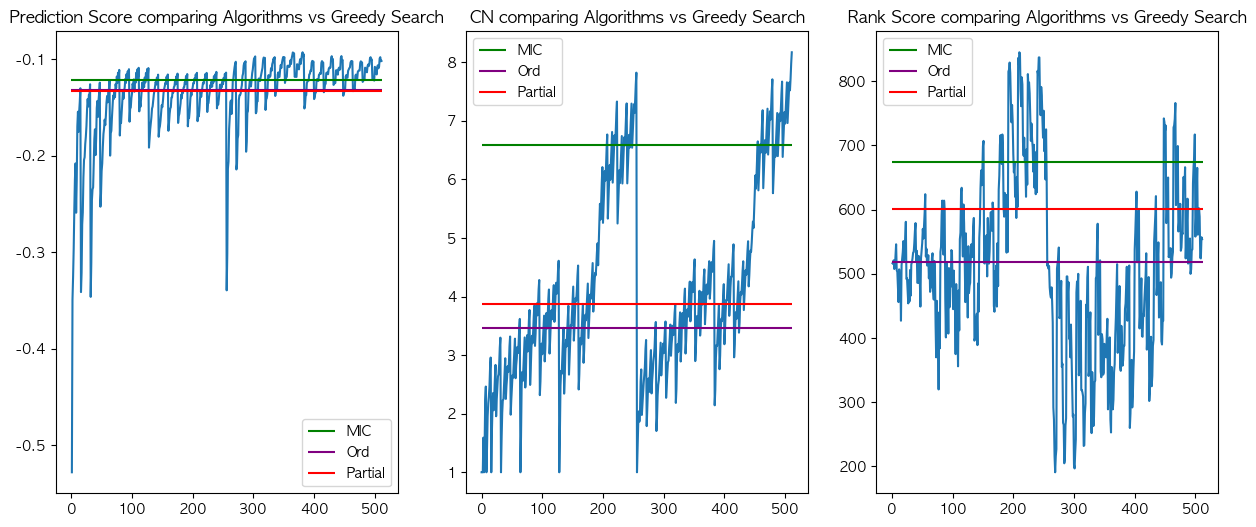

In [ ]:
pred_score_list_greedy = []
CN_list_greedy = []
p = X.shape[1]
index_list = pd.DataFrame([list(format(i, '0'+str(p)+'b')) for i in range(2**p)]).applymap(int).applymap(bool)
for i in index_list.values :
    dataset = X[:,i]
    pred_score_list_greedy += [bf.get_entropy_cv(dataset,y)]
    CN_list_greedy += [bf.get_CN(dataset)]
rank_list_greedy = pd.Series(pred_score_list_greedy).rank(ascending=False)+pd.Series(CN_list_greedy).rank()

mi_num = int("".join(sa_mi_result.astype(int).astype(str)),2)
ord_num = int("".join(sa_full_result.astype(int).astype(str)),2)
partial_num = int("".join(sa_partial_result.astype(int).astype(str)),2)

plt.figure(figsize = (15,6))
plt.subplot(131)
plt.plot(range(2**p),pred_score_list_greedy)
plt.hlines(pred_score_list_greedy[mi_num],0,2**p,colors="green",label="MIC")
plt.hlines(pred_score_list_greedy[ord_num],0,2**p,colors="purple",label="Ord")
plt.hlines(pred_score_list_greedy[partial_num],0,2**p,colors="red",label="Partial")
plt.title("Prediction Score comparing Algorithms vs Greedy Search")
plt.legend()

plt.subplot(132)
plt.plot(range(2**p),CN_list_greedy)
plt.hlines(CN_list_greedy[mi_num],0,2**p,colors="green",label="MIC")
plt.hlines(CN_list_greedy[ord_num],0,2**p,colors="purple",label="Ord")
plt.hlines(CN_list_greedy[partial_num],0,2**p,colors="red",label="Partial")
plt.title("CN comparing Algorithms vs Greedy Search")
plt.legend()

plt.subplot(133)
plt.plot(range(2**p),rank_list_greedy)
plt.hlines(rank_list_greedy[mi_num],0,2**p,colors="green",label="MIC")
plt.hlines(rank_list_greedy[ord_num],0,2**p,colors="purple",label="Ord")
plt.hlines(rank_list_greedy[partial_num],0,2**p,colors="red",label="Partial")
plt.title("Rank Score comparing Algorithms vs Greedy Search")
plt.legend()